<a href="https://colab.research.google.com/github/omarfathyz8/Teeth-Classification/blob/main/TeethClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import shutil

# Loading Datasets

### Drive Mounting

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### Unzip Dataset Folder

In [3]:
ZIP_PATH = "/content/drive/MyDrive/CellulaTechnologies/ComputerVision/TeethDataset.zip"
EXTRACT_DIR = "/content/TeethDataset"

In [4]:
if not os.path.exists(EXTRACT_DIR):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)

In [5]:
print("Extracted to:", EXTRACT_DIR)

Extracted to: /content/TeethDataset


### Data Directories

In [6]:
DATA_DIR = "/content/TeethDataset/Teeth_Dataset"
TRAIN_DIR = os.path.join(DATA_DIR, "Training")
TEST_DIR = os.path.join(DATA_DIR, "Testing")
VAL_DIR = os.path.join(DATA_DIR, 'Validation')

In [7]:
print('Training classes   :', os.listdir(TRAIN_DIR))
print('Testing classes    :', os.listdir(TEST_DIR))
print('Validation classes :', os.listdir(VAL_DIR))

Training classes   : ['CaS', 'OLP', 'MC', 'CoS', 'Gum', 'OT', 'OC']
Testing classes    : ['output', 'CaS', 'OLP', 'outputs', 'MC', 'CoS', 'output_image.jpg', 'Gum', 'OT', 'out', 'OC']
Validation classes : ['CaS', 'OLP', 'MC', 'CoS', 'Gum', 'OT', 'OC']


### Remove Extra Classes from Test Folder

In [8]:
# Allowed class names
allowed_classes = ['MC', 'OC', 'OLP', 'Gum', 'OT', 'CaS', 'CoS']

# Loop through test_dir and remove anything not in allowed_classes
for item in os.listdir(TEST_DIR):
    item_path = os.path.join(TEST_DIR, item)
    if item not in allowed_classes:
        if os.path.isdir(item_path):
            shutil.rmtree(item_path)  # remove folder
        else:
            os.remove(item_path)      # remove file
        print(f"Removed: {item}")

print("\nCleaned test directory successfully.\nClasses now:", os.listdir(TEST_DIR))

Removed: output
Removed: outputs
Removed: output_image.jpg
Removed: out

Cleaned test directory successfully.
Classes now: ['CaS', 'OLP', 'MC', 'CoS', 'Gum', 'OT', 'OC']


# Data Preprocessing

### Prepare Datasets

In [9]:
IMG_SIZE = (256, 256) # the images size is already 256*256
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


### Normalization

In [10]:
normalization_layer = layers.Rescaling(1/255.0)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

### Augmentation

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

In [12]:
# Apply augmentation only on the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Data Visualization

### Classes Distribution

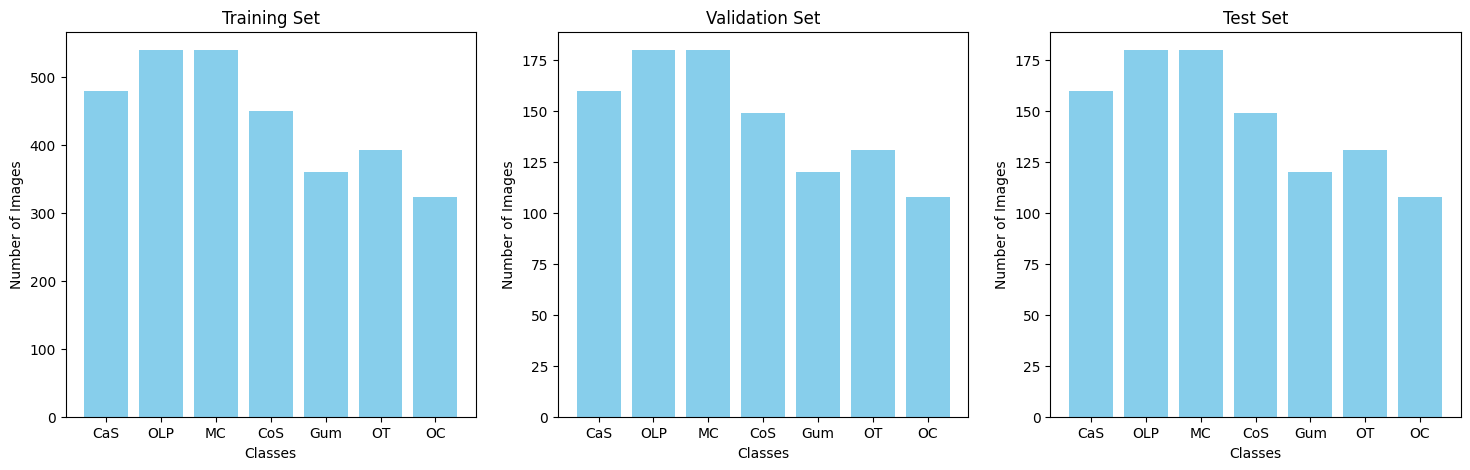

In [13]:
def count_images_per_class(directory):
    counts = {}
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):   # only count folders
            counts[cls] = len(os.listdir(cls_path))
    return counts

# Count for each split
train_counts = count_images_per_class(TRAIN_DIR)
val_counts   = count_images_per_class(VAL_DIR)
test_counts  = count_images_per_class(TEST_DIR)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, counts, title in zip(axes,
                             [train_counts, val_counts, test_counts],
                             ["Training Set", "Validation Set", "Test Set"]):
    ax.bar(counts.keys(), counts.values(), color="skyblue")
    ax.set_title(title)
    ax.set_xlabel("Classes")
    ax.set_ylabel("Number of Images")

plt.show()

### Before/After Augmentation

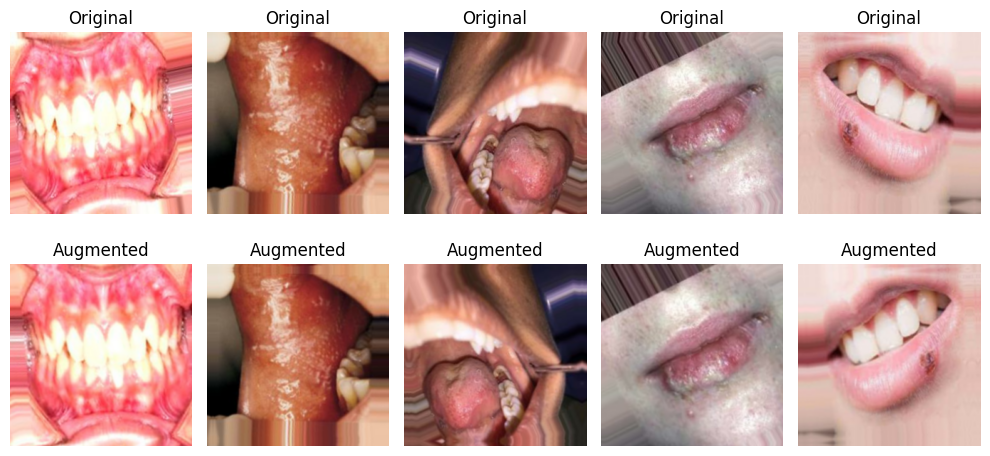

In [14]:
# Take one batch of normalized (but not augmented) images
for images, labels in train_ds.take(1):
    original_images = images[:5]  # take 5 images
    break

# Apply augmentation to the same images
augmented_images = data_augmentation(original_images, training=True)

# Plot comparison
plt.figure(figsize=(10, 5))
for i in range(5):
    # Original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow((original_images[i].numpy() * 255).astype("uint8"))
    plt.title("Original")
    plt.axis("off")

    # Augmented
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow((augmented_images[i].numpy() * 255).astype("uint8"))
    plt.title("Augmented")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Model

### Model Architecture

**Parameters Used and Why**
* (256,256,3) in input image size (256*256 pixels, 3 channels = RGB).
* (3,3) in Conv2D is for filter size (look at 3*3 pixels at a time).
* relu is used to introduce non-linearity and prevent vanishing gradients
* (2,2) in MaxPooling2D is for pooling window (takes max from every 2*2 block).
* Flatten is used to convert the 2D feature maps (from Conv/Pooling layers) into a 1D vector so it can be fed into Dense layers for classification.
* Softmax in last layer to convert outputs into probabilities for the 7 classes.
* Sparse Categorical Crossentropy is used because labels are integers (0-6), not one-hot vectors.

**Tunable Parameters**

1. **Conv layers**
   * Number of filters (32 / 64 / 128)
   * Filter size (3\*3 / 5*5)
   * Number of conv layers

2. **Pooling layers**
   * Pool size (2\*2 (default) / 3*3)
   * MaxPooling / AveragePooling

3. **Dense layers**
   * Number of neurons (128 / 256)
   * Number of dense layers

4. **Dropout**
   * Dropout rate (0.3 / 0.4 / 0.5)
   * Where to apply it (only dense, or also conv layers)

5. **Training setup**
   * Optimizer (adam / sgd / rmsprop)
   * Learning rate
   * Batch size
   * Epochs

In [15]:
# Define baseline CNN model
model = models.Sequential([
    layers.Input(shape=(256, 256, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(7, activation='softmax')
])

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,235,527 (50.49 MB)

 Trainable params: 13,235,527 (50.49 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [16]:
# Callbacks
# Stop early if val_loss do not improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Save the best model as baseline_cnn.keras
checkpoint = ModelCheckpoint("baseline_cnn.keras", save_best_only=True, monitor="val_loss")

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 71s 615ms/step - accuracy: 0.1759 - loss: 1.9946 - val_accuracy: 0.3239 - val_loss: 1.8294
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 64s 525ms/step - accuracy: 0.2906 - loss: 1.7859 - val_accuracy: 0.3628 - val_loss: 1.5842
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 49s 508ms/step - accuracy: 0.3836 - loss: 1.5881 - val_accuracy: 0.4698 - val_loss: 1.3640
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 507ms/step - accuracy: 0.4530 - loss: 1.4028 - val_accuracy: 0.4893 - val_loss: 1.3669
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 510ms/step - accuracy: 0.5102 - loss: 1.3092 - val_accuracy: 0.5856 - val_loss: 1.1479
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 49s 507ms/step - accuracy: 0.5514 - loss: 1.2096 - val_accuracy: 0.6362 - val_loss: 1.0300
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 513ms/step - accuracy: 0.6011 - loss: 1.0831 - val_accuracy: 0.6488 - val_loss: 0.9542
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 513ms/step - accuracy: 0.6487 - loss: 0.9858 - val_accu

### Visualize Accuracy and Loss

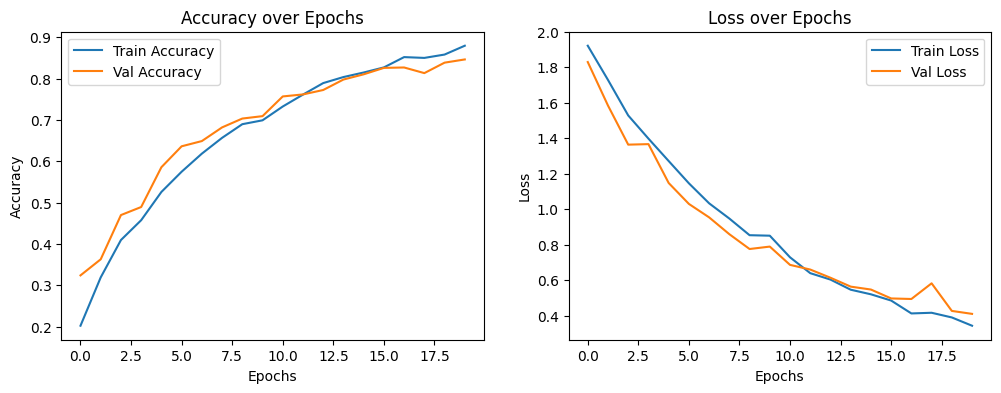

In [17]:
# Plot Accuracy
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Evaluating

In [18]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8520 - loss: 0.4782
Test Accuracy: 0.8589494228363037
Test Loss: 0.43456974625587463
